# Inverse filter

In [1]:
import numpy as np
import scipy
from scipy import signal
from skimage.io import imread
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'skimage'

A random filter

In [ ]:
a = np.array([1])
L = 10
# sigma = 2
# b = signal.gaussian(L+1, sigma)
b = np.random.normal(0, 0.1, L+1)
b = b / sum(b)
plt.stem(b)
plt.title('A random finite impulse response (FIR) filter')
plt.savefig('randFIR.pdf', format='pdf', bbox_inches='tight')

1D filtering

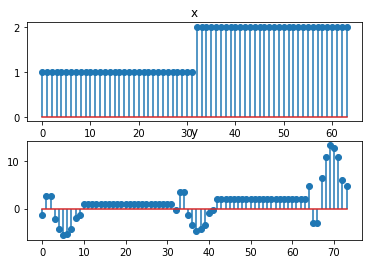

In [3]:
x = np.concatenate((np.ones(32), 2*np.ones(32)))
y = signal.lfilter(b, a, np.append(x, np.zeros(L)))
plt.subplot(211)
plt.stem(x)
plt.title('x')
plt.subplot(212)
plt.stem(y)
plt.title('y')
plt.savefig('1D_filtering.pdf', format='pdf', bbox_inches='tight')

2D separable filtering

In [4]:
def lfilter2(b, a, im):
    L = b.size - 1
    im1 = signal.lfilter(b, a, np.append(im, np.zeros((L, im.shape[1])), axis=0), axis=0)
    im2 = signal.lfilter(b, a, np.append(im1, np.zeros((im1.shape[0], L)), axis=1), axis=1)
    return im2

Test image

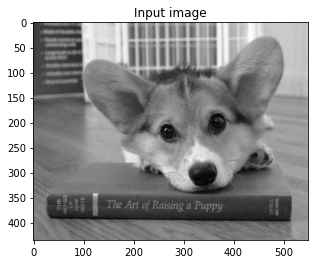

In [5]:
im = imread('resources/test-image.jpg')
plt.imshow(im, 'gray');
plt.title('Input image')
plt.savefig('input_im.pdf', format='pdf', bbox_inches='tight')

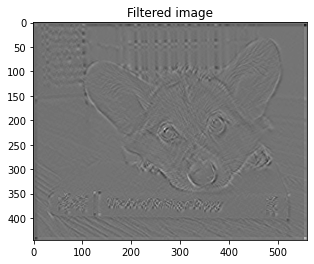

In [6]:
im2 = lfilter2(b, a, im)
plt.imshow(im2, 'gray')
plt.title('Filtered image')
plt.savefig('filtered_im.pdf', format='pdf', bbox_inches='tight')

Factorize $B(z) = B_i(z) B_o(z)$ where $B_i(z)$ and $B_o(z)$ have roots inside and outside the unit circle, respectively.

In [21]:
r = np.roots(b)
ri = r[np.abs(r) < 1]
ro = r[np.abs(r) >= 1]
bi = np.poly(ri)
bo = np.poly(ro)

np.set_printoptions(precision=2)
print('abs(r) =', np.abs(r))
print('bi = ', bi)
print('bo = ', bo)

abs(r) = [2.1  2.1  1.04 1.07 0.91 0.91 0.8  0.8  0.81 0.81]
bi =  [1.   1.14 1.43 1.08 1.   0.44 0.35]
bo =  [ 1.   -4.04  3.17  4.66 -4.91]


In [22]:
# Verify factorization
b2 = np.convolve(bi, bo) * b[0]
print('b2 - b = ', b2 - b)

b2 - b =  [ 0.00e+00  3.55e-15 -5.94e-15 -1.42e-14 -2.49e-14  2.86e-14 -2.16e-14
  3.33e-15  1.78e-15  6.44e-15 -1.33e-15]


In [9]:
# Causal filter with poles inside unit circle
w = signal.lfilter(a, bi, y)

In [10]:
# Anti-causal filter with poles outside unit circle
# Flip signal and coefficients for anti-causal computation
K = bo.size
af = np.zeros(K)
af[K-1] = 1
bof = np.flip(bo)
xr = np.flip(signal.lfilter(af, bof, np.flip(w))) / b[0]

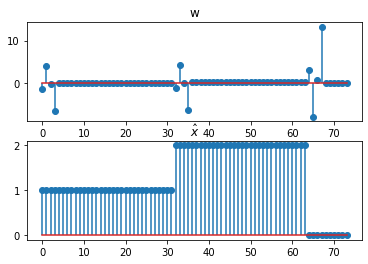

In [11]:
plt.subplot(211)
plt.stem(w)
plt.title('w')
plt.subplot(212)
plt.stem(xr)
plt.title('$\hat{x}$')
plt.savefig('inverse_proc.pdf', format='pdf', bbox_inches='tight')

In [12]:
def inverse_filter(b, y):
    # Factorize B(z) = B_i(z) B_o(z), where B_i and B_o have roots inside and outside unit circle
    r = np.roots(b)
    ri = r[np.abs(r) < 1]
    ro = r[np.abs(r) >= 1]
    bi = np.poly(ri)
    bo = np.poly(ro)
    
    # Causal filter with poles inside unit circle
    w = signal.lfilter(a, bi, y)
    
    # Anti-causal filter with poles outside unit circle
    # Flip signal and coefficients for anti-causal computation
    K = bo.size
    af = np.zeros(K)
    af[K-1] = 1
    bof = np.flip(bo)
    xr = np.flip(signal.lfilter(af, bof, np.flip(w))) / b[0]
    
    # Truncate added zeros due to extended filtering
    return xr[:-b.size+1]

Reconstruction error xr2 - x = 
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.88e-16  3.55e-15  1.11e-14
  2.98e-14  7.19e-14  1.62e-13  3.43e-13  6.80e-13  1.26e-12  2.11e-12
  3.05e-12  3.11e-12 -7.71e-13 -1.69e-11 -6.51e-11 -1.91e-10 -4.88e-10
 -1.15e-09 -2.51e-09 -5.15e-09 -9.90e-09 -1.76e-08 -2.78e-08 -3.58e-08
 -2.30e-08  6.40e-08  3.62e-07  1.19e-06  3.24e-06  7.94e-06  1.80e-05
  3.83e-05  7.63e-05  1.42e-04  2.40e-04  3.52e-04  3.74e-04 -2.91e-05
 -1.77e-03 -7.05e-03 -2.09e-02 -5.39e-02 -1.27e-01 -2.80e-01 -5.77e-01
 -1.11e+00 -1.99e+00 -3.19e+00 -4.18e+00 -2.99e+00  6.29e+00  3.87e+01
  1.30e+02  3.57e+02  8.80e+02  2.01e+03  4.28e+03  8.57e+03  1.60e+04
  2.73e+04]


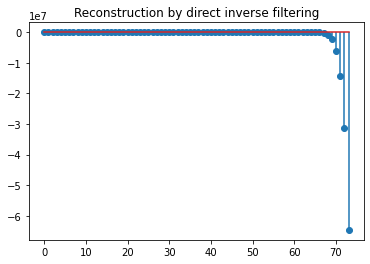

In [13]:
xr2 = signal.lfilter(a, b, y)
plt.stem(xr2)
plt.title('Reconstruction by direct inverse filtering')
plt.savefig('direct_inverse.pdf', format='pdf', bbox_inches='tight')
e = xr2[:-b.size+1] - x
np.set_printoptions(precision=2)
print('Reconstruction error xr2 - x = \n', e)

Text(0.5, 1.0, 'Reconstruction by causal + anti-causal inverse filtering')

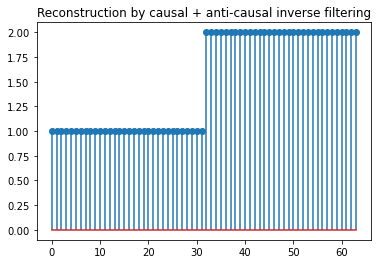

In [14]:
xr = inverse_filter(b, y)
plt.stem(xr)
plt.title('Reconstruction by causal + anti-causal inverse filtering')

## Consider adding noise

In [15]:
e = np.random.normal(0, 0.01, y.size)

Text(0.5, 1.0, 'Reconstruction by direct inverse filter')

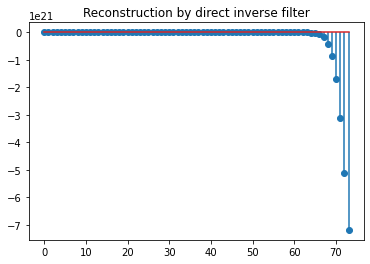

In [16]:
xr2 = signal.lfilter(a, b, y+e)
plt.stem(xr2)
plt.title('Reconstruction by direct inverse filter')

Text(0.5, 1.0, 'Reconstruction by causal + anti-causal inverse filtering')

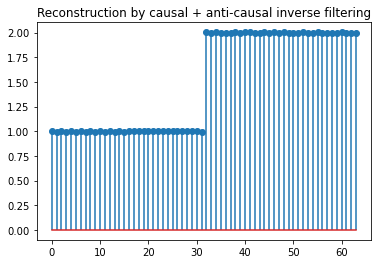

In [17]:
xr = inverse_filter(b, y+e)
plt.stem(xr)
plt.title('Reconstruction by causal + anti-causal inverse filtering')

2D inverse filtering

In [18]:
def inverse_filter2(b, y):
    # Factorize B(z) = B_i(z) B_o(z), where B_i and B_o have roots inside and outside unit circle
    r = np.roots(b)
    ri = r[np.abs(r) < 1]
    ro = r[np.abs(r) >= 1]
    bi = np.poly(ri)
    bo = np.poly(ro)
    
    # Causal filter with poles inside unit circle
    w1 = signal.lfilter(a, bi, y, axis=0)
    w2 = signal.lfilter(a, bi, w1, axis=1)
    
    # Anti-causal filter with poles outside unit circle
    # Flip signal for anti-causal computation
    K = bo.size - 1
    bof = np.flip(bo)
    af = np.append(np.zeros(K), np.array([1]))
    xr1 = np.flip(signal.lfilter(af, bof, np.flip(w2, axis=0), axis=0), axis=0) / b[0]
    xr2 = np.flip(signal.lfilter(af, bof, np.flip(xr1, axis=1), axis=1), axis=1) / b[0]
    
    # Truncate the added zeros from extended filtering
    return xr2[:-b.size+1, :-b.size+1]

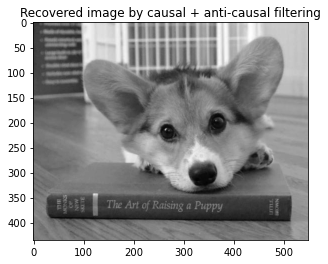

In [19]:
imr = inverse_filter2(b, im2)
plt.imshow(imr, 'gray', vmin=0, vmax=255)
plt.title('Recovered image by causal + anti-causal filtering')
plt.savefig('inverse_proc_im.pdf', format='pdf', bbox_inches='tight')

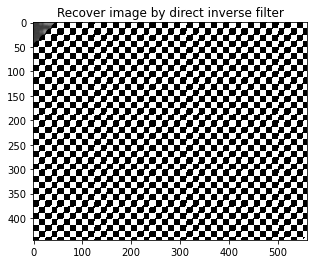

In [20]:
imr2 = lfilter2(a, b, im2)
plt.imshow(imr2, 'gray', vmin=0, vmax=255)
plt.title('Recover image by direct inverse filter')
plt.savefig('direct_inverse_im.pdf', format='pdf', bbox_inches='tight')